# Data distribution for Shasta Reservoir
In previous experiments, we note that model performance in testing is much worse than in training or even validation. In this notebook, we compare the distributions (CDF) for the input hydrology and the output releases for the train (60%), validation (20%), and test (20%) datsets. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import mannwhitneyu

In [2]:
from src.data.data_processing import *
from src.data.data_fetching import *

In [3]:
print(f'Old working directory: {os.getcwd()}')
# change directory out of subdirectory 'experiments'
os.chdir('..')
print(f'Current working directory: {os.getcwd()}')

Old working directory: c:\Users\mattc\Documents\DL-reservoir-modeling\experiments
Current working directory: c:\Users\mattc\Documents\DL-reservoir-modeling


In [4]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()
# Remove na
df = df.dropna(how='any')
data = df.values

In [5]:
# Split the data into train/validation/test sets
data_train, data_val, data_test = train_val_test(data=data, train_frac=0.6, val_frac=0.2, test_frac=0.2)

### Compare hydrology (inflow) CDF's

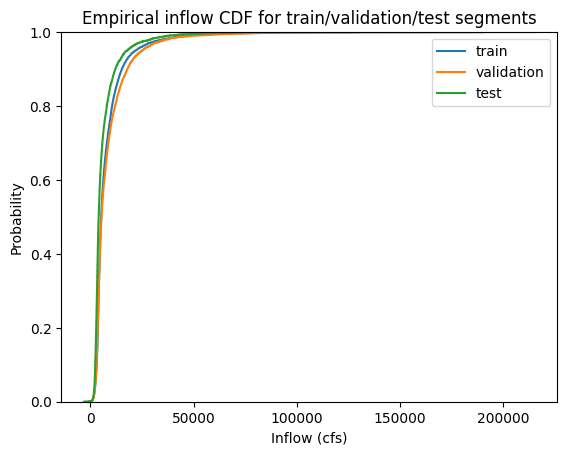

In [6]:
fig, ax = plt.subplots()
ax.ecdf(data_train[:, 0], label='train')
ax.ecdf(data_val[:, 0], label='validation')
ax.ecdf(data_test[:, 0], label='test')
ax.legend()
ax.set_title('Empirical inflow CDF for train/validation/test segments')
ax.set_ylabel('Probability')
ax.set_xlabel('Inflow (cfs)')
plt.show()

### Compare outflow CDF's

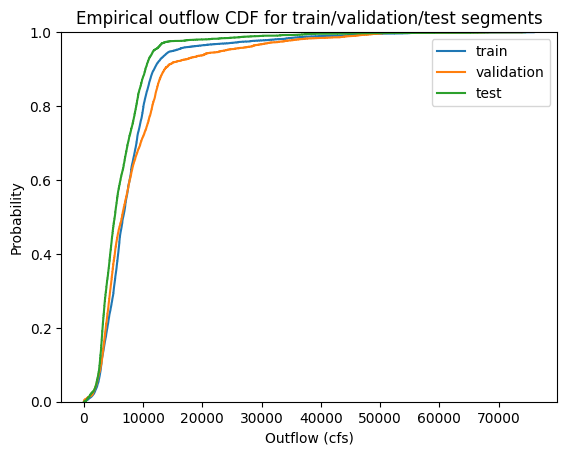

In [7]:
fig, ax = plt.subplots()
ax.ecdf(data_train[:, 1], label='train')
ax.ecdf(data_val[:, 1], label='validation')
ax.ecdf(data_test[:, 1], label='test')
ax.legend()
ax.set_title('Empirical outflow CDF for train/validation/test segments')
ax.set_ylabel('Probability')
ax.set_xlabel('Outflow (cfs)')
plt.show()

### Is the hydrology for the test set significantly drier than the training set?
Test the difference in distribution using a one sided Mann-Whiteney U-test

In [8]:
mannwhitneyu(x=data_train[:, 0], y=data_test[:, 0], alternative='greater').pvalue

6.196803448023914e-183

How about comparing the validation and train set?

In [9]:
mannwhitneyu(x=data_train[:, 0], y=data_val[:, 0], alternative='greater').pvalue

0.9978372613828599

The test set appears to be significantly drier than the trianing set, while the same is not true for the validation set.

## How does nonstationarity affect model performance
In this experiment, we train a model on the first 10 years (validating on the next 5 years for early stopping), and examine R^2 on a rolling window to detect shifts in performance. For simplicity, we use the model architecture from Model 1(a) and tune hyperparameters manually.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from math import floor

from src.data.data_processing import *
from src.data.data_fetching import *
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *
from src.models.hyperparameter_tuning import *

In [6]:
def data_processing(name, transform_type, train_frac=0.75, val_frac=0.25, left='1944-01-01', right='1983-12-31', log_names=[], return_scaler=False):
    """
    Run data processing pipeline. Return Dataloader objects for training and validation data
    Params:
    name -- str, name of reservoir to read
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    left -- str (YYYY-MM-DD), beginning boundary of time window
    right -- str (YYYY-MM-DD), end boundary of time window
    log_names -- list of column names (str) to take log of before running rest of pipeline. E.g. ['inflow', 'outflow', 'storage']
    return_scaler -- bool, whether or not to return src.data.data_processing.time_scaler() object
    """

    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window
    df = df[left:right].copy()

    # Take log of df columns that are in log_names
    for column_name in df.columns:
        if column_name in log_names:
            df[column_name] = np.log(df[column_name])
        else:
            continue

    # Run data processing pipeline
    pipeline = processing_pipeline(train_frac=train_frac, val_frac=val_frac, test_frac=0, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
    # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
    ts_train, ts_val, ts_test = pipeline.process_data(df) 

    # Separate inputs(X) and targets (y)
    # select inflow and doy as input features
    X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, :, [0, 3]]
    # select outflow as target feature
    y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, :, [1]]

    if return_scaler:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test), pipeline.scaler
    else:
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [7]:
def rolling_windows(df, win_size=30, transform_type='standardize'):
    """ 
    Return list of (X, y) tensors corresponding to rolling windows
    Params:
    df -- pandas df (timesteps, features) containing entire time period
    win_size -- int, size of rolling window
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    Return:
    tensor_list -- list of (X, y) tensors
    right_edge_list -- list of years corresponding to the right edge of each rolling window
    """
    # Get first and last year
    first_year = df.index[0].year
    last_year = df.index[-1].year

    # Create an array of right edges
    # -1 on start to account for using 12/31 instead of 1/1, +1 on end to account for open iterval
    right_edge_list = np.arange(start=first_year+win_size-1, stop=last_year+1)

    # Iterate through rolling windows
    left_edge = first_year # Initialize left edge year
    tensor_list = [] # List to store resulting (X,y) tensors for each window
    for right_edge in right_edge_list:
        left_date = f'{left_edge}-01-01'
        right_date = f'{right_edge}-12-31'
        left_edge += 1

        # Subset current window from df
        df_window = df[left_date:right_date].copy()
        # Process data
        pipeline = processing_pipeline(train_frac=1.0, val_frac=0, test_frac=0, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
        # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
        tensor, _, _ = pipeline.process_data(df_window)
        # Separate inputs(X) and targets (y)
        X = tensor[:, :, [0, 3]] # select inflow and doy as input features
        y = tensor[:, :, [1]] # select outflow as target feature
        tensor_list.append((X, y)) # save results
        
    return tensor_list, right_edge_list

In [8]:
def sliding_windows(df, win_size=10, transform_type='standardize'):
    """ 
    Return list of (X, y) tensors corresponding to sliding windows
    Params:
    df -- pandas df (timesteps, features) containing entire time period
    win_size -- int, size of rolling window
    transform_type -- str, in preprocessing, whether to 'standardize' or 'normalize' the data
    Return:
    tensor_list -- list of (X, y) tensors
    right_edge_list -- list of years corresponding to the right edge of each rolling window
    """
    # Get first and last year
    first_year = df.index[0].year
    last_year = df.index[-1].year

    # Number of windows
    num_windows = int(floor((last_year - first_year + 1) / win_size)) + 1

    # Iterate through rolling windows
    left_edge = first_year # Initialize first left edge year
    right_edge = first_year + win_size - 1 # Initialize first right edge year
    right_edge_list = [] # List to store right edge years
    tensor_list = [] # List to store resulting (X,y) tensors for each window
    for i in range(num_windows):
        right_edge_list.append(right_edge)
        left_date = f'{left_edge}-01-01'
        right_date = f'{right_edge}-12-31'
        left_edge += win_size
        if right_edge + win_size > last_year:
            right_edge = last_year
        else:
            right_edge += win_size
    

        # Subset current window from df
        df_window = df[left_date:right_date].copy()
        # Process data
        pipeline = processing_pipeline(train_frac=1.0, val_frac=0, test_frac=0, chunk_size=3*365, pad_value=-1, transform_type=transform_type, fill_na_method='mean')
        # Train/val/test tensors of shape (#chunks, chunksize, [inflow, outflow, storage, doy])
        tensor, _, _ = pipeline.process_data(df_window)
        # Separate inputs(X) and targets (y)
        X = tensor[:, :, [0, 3]] # select inflow and doy as input features
        y = tensor[:, :, [1]] # select outflow as target feature
        tensor_list.append((X, y)) # save results
        
    return tensor_list, right_edge_list

In [9]:
def r2_window(model, X, y):
    """
    Evaluate the R2 score for given feature (X) and target (y) tensors 
    """
    # Get predictions
    y_hat= predict(model, X)
    # Flatten and remove padding values
    y_hat, y = flatten_rm_pad(y_hat=y_hat, y=y)
    assert len(y_hat) == len(y)
    # Evaluate R2 score
    r2 = r2_score(y_pred=y_hat, y_true=y)
    return r2

In [10]:
def get_moving_performance(model, name, type, win_size, left='1944-01-01', right='2022-12-31'):
    """
    Return R2 performance on rolling or sliding windows
    Params:
    model -- PyTorch model to make predictions on
    name -- str, name of reservoir to fetch data from
    type -- str, 'rolling' or 'sliding' 
    win_size -- size of moving window
    left / right -- str, define dates for data window
    Returns:
    list of R2 scores for each window, list of years corresponding to right edge
    """
    # Read in data, columns are [inflow, outflow, storage]
    df = usbr_fetch_data(name=name, vars=['inflow', 'outflow', 'storage'])
    # Add day of the year (doy) as another column
    df['doy'] = df.index.to_series().dt.dayofyear
    # Select data window (all data)
    df = df[left:right].copy()

    # Get (X, y) tensors corresponding to moving windows
    if type == 'rolling':
        tensor_list, right_years = rolling_windows(df, win_size=win_size, transform_type='standardize')
    elif type == 'sliding':
        tensor_list, right_years = sliding_windows(df, win_size=win_size, transform_type='standardize')
    else:
        raise Exception('Invalid window type')
    
    # collect R2 scores for each moving window
    R2_list = [] 
    for X, y in tensor_list:
        R2_list.append(r2_window(model, X, y))

    return R2_list, right_years

### Train a model using initial training window

In [11]:
# Run data processing pipeline
left_window_shasta = '1944-01-01'
right_window_shasta = '1983-12-31'
train_frac = 0.75
val_frac = 0.25
result = data_processing(name='Shasta', transform_type='standardize', left=left_window_shasta, right=right_window_shasta, train_frac=train_frac, val_frac=val_frac)
# Create PyTorch dataset and dataloader
dataset_train, dataset_val = (TensorDataset(*result[0]), TensorDataset(*result[1]))
# shuffle = False to preserve time order
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                                    DataLoader(dataset_val, batch_size=1, shuffle=False))

# Instantiate model
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
dropout_prob = 0.3
num_layers = 1

torch.manual_seed(0)
model = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                            hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training epochs:  18%|█▊        | 176/1000 [00:16<01:19, 10.40it/s]


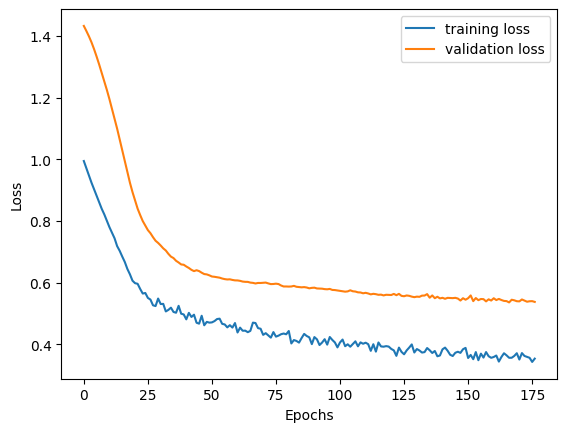

In [12]:
# Run training loop
train_losses, val_losses = training_loop(model=model, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train, 
                                        dataloader_val=dataloader_val, epochs=1000)
# Plot train/validation plot
plot_train_val(train_losses=train_losses, val_losses=val_losses)
plt.show()

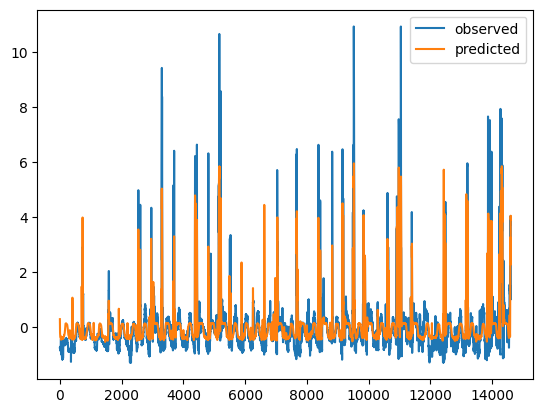

In [13]:
# Training and validation performance

# Get predictions
y_hat_train, y_hat_val= predict(model, result[0][0]), predict(model, result[1][0])
# Flatten and remove padding values
y_hat_train, y_train = flatten_rm_pad(y_hat=y_hat_train, y=result[0][1])
y_hat_val, y_val = flatten_rm_pad(y_hat=y_hat_val, y=result[1][1])
# Find R2 metrics
r2_train_shasta = r2_score(y_pred=y_hat_train, y_true=y_train)
r2_val_shasta = r2_score(y_pred=y_hat_val, y_true=y_val)
# Plot
# Concat results, check dimensions with datetime index
y_hat, y = torch.cat((y_hat_train, y_hat_val)), torch.cat((y_train, y_val))
len(y_hat) == len(y)
plt.plot(y, label='observed')
plt.plot(y_hat, label='predicted')
plt.legend()
plt.show()

In [14]:
print(r2_train_shasta, r2_val_shasta)

0.7138378337397198 0.6214341150151337


### Evaluate performance on a rolling window

In [15]:
R2_rolling_shasta, rolling_years_shasta = get_moving_performance(model=model, name='Shasta', type='rolling', win_size=20)

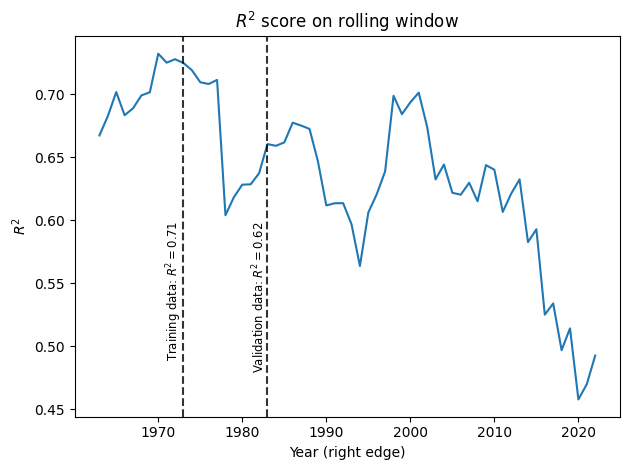

In [17]:
# Plot result
fig, ax = plt.subplots()
ax.plot(rolling_years_shasta, R2_rolling_shasta)
# Label training and validation window
data_size_shasta = pd.to_datetime(right_window_shasta).year - pd.to_datetime(left_window_shasta).year + 1
train_size_shasta = int(round(data_size_shasta * train_frac))
ax.axvline(x=pd.to_datetime(left_window_shasta).year + train_size_shasta -1, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
ax.text(x=pd.to_datetime(left_window_shasta).year + train_size_shasta-0.9, y=0.6, s=f'Training data: $R^2={round(r2_train_shasta, 2)}$ ', ha='right', va='top', size='small', rotation=90)
ax.axvline(x=pd.to_datetime(right_window_shasta).year, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
ax.text(x=pd.to_datetime(right_window_shasta).year, y=0.6, s=f'Validation data: $R^2={round(r2_val_shasta, 2)}$ ', ha='right', va='top', size='small', rotation=90)
ax.set_ylabel('$R^2$')
ax.set_xlabel('Year (right edge)')
ax.set_title('$R^2$ score on rolling window')
plt.tight_layout()
plt.show()

### Evaluate performance on sliding windows
Rolling windows may be make it difficult to discern where the influence of the training set ends.

In [18]:
R2_sliding_shasta, sliding_years_shasta = get_moving_performance(model=model, name='Shasta', type='sliding', win_size=20)

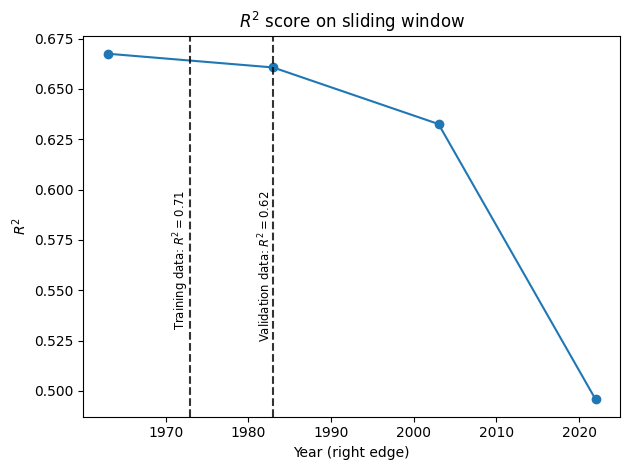

In [19]:
# Plot result
fig, ax = plt.subplots()
ax.plot(sliding_years_shasta, R2_sliding_shasta, marker='o')
# Label training and validation window
ax.axvline(x=pd.to_datetime(left_window_shasta).year + train_size_shasta -1, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
ax.text(x=pd.to_datetime(left_window_shasta).year + train_size_shasta-0.9, y=0.6, s=f'Training data: $R^2={round(r2_train_shasta, 2)}$ ', ha='right', va='top', size='small', rotation=90)
ax.axvline(x=pd.to_datetime(right_window_shasta).year, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
ax.text(x=pd.to_datetime(right_window_shasta).year, y=0.6, s=f'Validation data: $R^2={round(r2_val_shasta, 2)}$ ', ha='right', va='top', size='small', rotation=90)
ax.set_ylabel('$R^2$')
ax.set_xlabel('Year (right edge)')
ax.set_title('$R^2$ score on sliding window')
plt.tight_layout()
plt.show()

### What if we take the log of the original data (inflow/outflow)?

In [131]:
# Run data processing pipeline
left_window = '1944-01-01'
right_window = '1983-12-31'
train_frac = 0.75
val_frac = 0.25
result_log = data_processing(name='Shasta', transform_type='standardize', left=left_window, 
                             right=right_window, train_frac=train_frac, val_frac=val_frac,
                             log_names=['inflow', 'outflow', 'storage'], return_scaler=True)
# Create PyTorch dataset and dataloader
dataset_train_log, dataset_val_log = (TensorDataset(*result_log[0]), TensorDataset(*result_log[1]))
scaler = result_log[-1]
# shuffle = False to preserve time order
dataloader_train_log, dataloader_val_log = (DataLoader(dataset_train_log, batch_size=1, shuffle=False), 
                                                    DataLoader(dataset_val_log, batch_size=1, shuffle=False))

In [132]:
# Instantiate model
input_size = 2
hidden_size1 = 25
hidden_size2 = 20
output_size = 1
dropout_prob = 0.1
num_layers = 1

torch.manual_seed(0)
model_log = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                            hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_log.parameters(), lr=0.001)

Training epochs:   4%|▎         | 36/1000 [00:03<01:28, 10.91it/s]


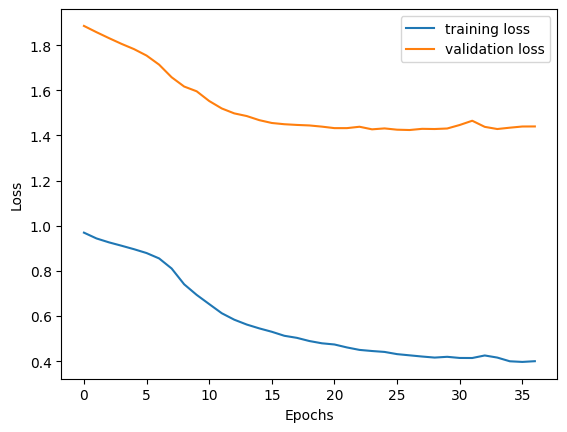

In [133]:
# Run training loop
train_losses_log, val_losses_log = training_loop(model=model_log, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train_log, 
                                        dataloader_val=dataloader_val_log, epochs=1000)
# Plot train/validation plot
plot_train_val(train_losses=train_losses_log, val_losses=val_losses_log)
plt.show()

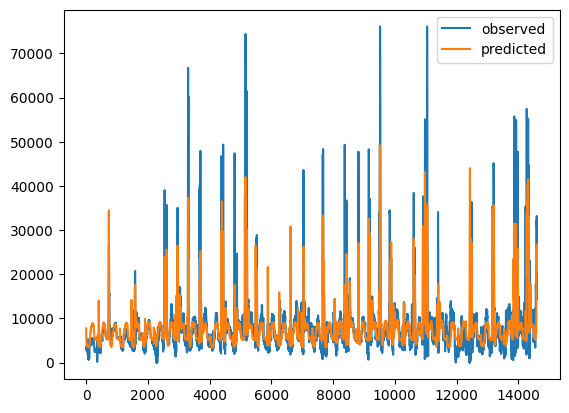

In [134]:
# Training and validation performance

# Get predictions
y_hat_train_log, y_hat_val_log= predict(model_log, result_log[0][0]), predict(model_log, result_log[1][0])

# Flatten and remove padding values
y_hat_train_log, y_train_log = flatten_rm_pad(y_hat=y_hat_train_log, y=result_log[0][1])
y_hat_val_log, y_val_log = flatten_rm_pad(y_hat=y_hat_val_log, y=result_log[1][1])

# Undo scaling
y_hat_train_log, y_train_log = y_hat_train_log * scaler.std[0, 1] + scaler.mean[0, 1], y_train_log * scaler.std[0, 1] + scaler.mean[0, 1]
y_hat_val_log, y_val_log = y_hat_val_log * scaler.std[0, 1] + scaler.mean[0, 1], y_val_log * scaler.std[0, 1] + scaler.mean[0, 1]

# Undo logarithm
y_hat_train_log, y_train_log = np.exp(y_hat_train_log), np.exp(y_train_log)
y_hat_val_log, y_val_log = np.exp(y_hat_val_log), np.exp(y_val_log)

# Find R2 metrics
r2_train_log = r2_score(y_pred=y_hat_train_log, y_true=y_train_log)
r2_val_log = r2_score(y_pred=y_hat_val_log, y_true=y_val_log)

# Plot
# Concat results, check dimensions with datetime index
y_hat_log, y_log = torch.cat((y_hat_train_log, y_hat_val_log)), torch.cat((y_train_log, y_val_log))
len(y_hat_log) == len(y_log)
plt.plot(y_log, label='observed')
plt.plot(y_hat_log, label='predicted')
plt.legend()
plt.show()

In [135]:
r2_train_log, r2_val_log

(0.6838264297594594, 0.5924283614983905)

## Does Folsom Reservoir have the same pattern?

### Train a model on initial window

In [20]:
# First date after leading na's
usbr_fetch_data(name='Folsom', vars=['inflow', 'outflow', 'storage']).isna().idxmin().max()

Timestamp('1955-03-01 08:00:00')

In [22]:
# Run data processing pipeline
left_window_folsom = '1956-01-01'
right_window_folsom = '1995-12-31'
train_frac = 0.75
val_frac = 0.25
result = data_processing(name='Folsom', transform_type='standardize', left=left_window_folsom, right=right_window_folsom, train_frac=train_frac, val_frac=val_frac)
# Create PyTorch dataset and dataloader
dataset_train, dataset_val = (TensorDataset(*result[0]), TensorDataset(*result[1]))
# shuffle = False to preserve time order
dataloader_train, dataloader_val = (DataLoader(dataset_train, batch_size=1, shuffle=False), 
                                                    DataLoader(dataset_val, batch_size=1, shuffle=False))

# Instantiate model
input_size = 2
hidden_size1 = 10
hidden_size2 = 10
output_size = 1
dropout_prob = 0.3
num_layers = 1

torch.manual_seed(0)
model_folsom = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                            hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_folsom.parameters(), lr=0.001)

Training epochs:  15%|█▌        | 152/1000 [00:15<01:27,  9.70it/s]


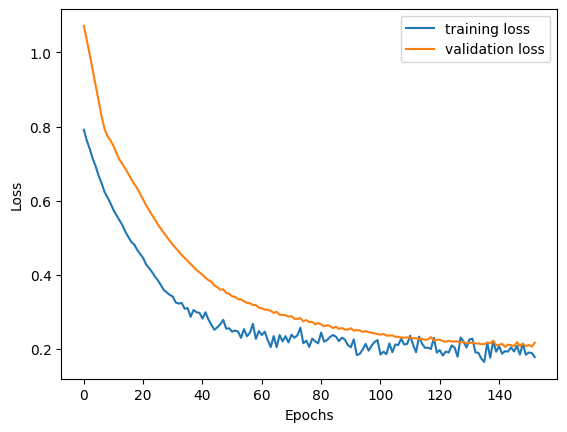

In [23]:
# Run training loop
train_losses, val_losses = training_loop(model=model_folsom, criterion=criterion, optimizer=optimizer, 
                                        patience=10, dataloader_train=dataloader_train, 
                                        dataloader_val=dataloader_val, epochs=1000)
# Plot train/validation plot
plot_train_val(train_losses=train_losses, val_losses=val_losses)
plt.show()

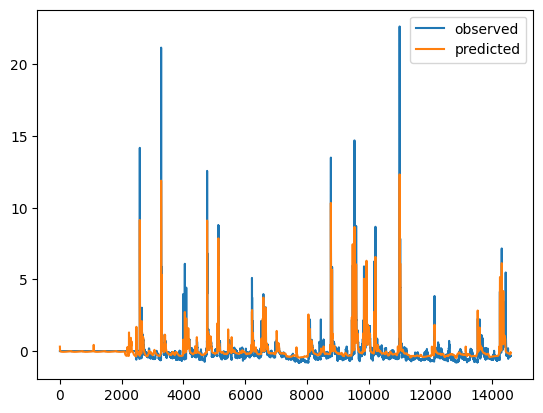

In [24]:
# Training and validation performance

# Get predictions
y_hat_train, y_hat_val= predict(model_folsom, result[0][0]), predict(model_folsom, result[1][0])
# Flatten and remove padding values
y_hat_train, y_train = flatten_rm_pad(y_hat=y_hat_train, y=result[0][1])
y_hat_val, y_val = flatten_rm_pad(y_hat=y_hat_val, y=result[1][1])
# Find R2 metrics
r2_train_folsom = r2_score(y_pred=y_hat_train, y_true=y_train)
r2_val_folsom = r2_score(y_pred=y_hat_val, y_true=y_val)
# Plot
# Concat results, check dimensions with datetime index
y_hat, y = torch.cat((y_hat_train, y_hat_val)), torch.cat((y_train, y_val))
len(y_hat) == len(y)
plt.plot(y, label='observed')
plt.plot(y_hat, label='predicted')
plt.legend()
plt.show()

In [25]:
print(r2_train_folsom, r2_val_folsom)

0.8176362258726234 0.7545858485283501


### Performance on rolling window

In [37]:
R2_rolling_folsom, rolling_years_folsom = get_moving_performance(model=model_folsom, name='Folsom', type='rolling', win_size=20, left=left_window_folsom)

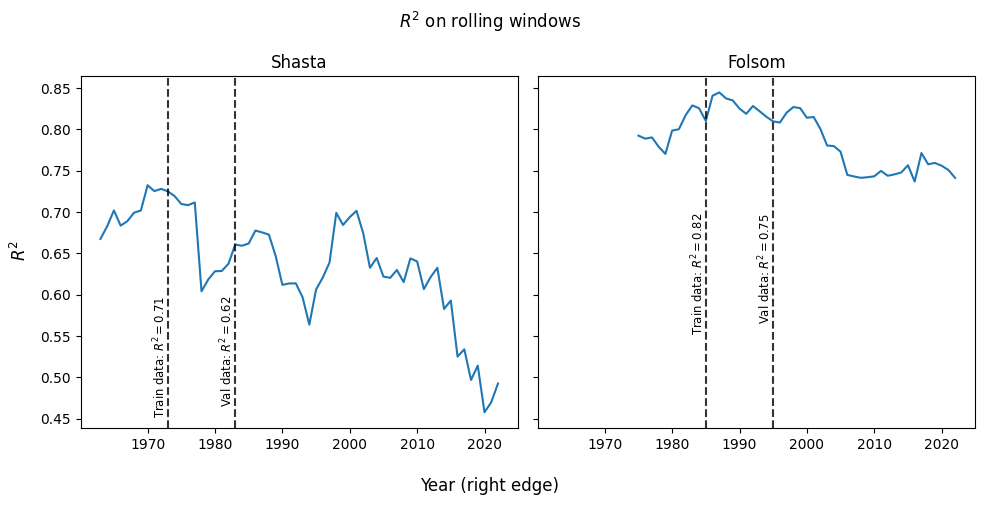

In [41]:
# Plot result
fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(10, 5))
axes[0].plot(rolling_years_shasta, R2_rolling_shasta)
axes[1].plot(rolling_years_folsom, R2_rolling_folsom)

# Label training and validation window
data_size_folsom = pd.to_datetime(right_window_folsom).year - pd.to_datetime(left_window_folsom).year + 1
train_size_folsom = int(round(data_size_folsom * train_frac))
# Folsom plot labels
axes[1].axvline(x=pd.to_datetime(left_window_folsom).year + train_size_folsom -1, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
axes[1].text(x=pd.to_datetime(left_window_folsom).year + train_size_folsom-0.9, y=0.7, s=f'Train data: $R^2={round(r2_train_folsom, 2)}$ ', ha='right', va='top', size='small', rotation=90)
axes[1].axvline(x=pd.to_datetime(right_window_folsom).year, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
axes[1].text(x=pd.to_datetime(right_window_folsom).year, y=0.7, s=f'Val data: $R^2={round(r2_val_folsom, 2)}$ ', ha='right', va='top', size='small', rotation=90)
axes[1].set_title('Folsom')
# Shasta plot labels
axes[0].axvline(x=pd.to_datetime(left_window_shasta).year + train_size_shasta -1, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
axes[0].text(x=pd.to_datetime(left_window_shasta).year + train_size_shasta-0.9, y=0.6, s=f'Train data: $R^2={round(r2_train_shasta, 2)}$ ', ha='right', va='top', size='small', rotation=90)
axes[0].axvline(x=pd.to_datetime(right_window_shasta).year, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
axes[0].text(x=pd.to_datetime(right_window_shasta).year, y=0.6, s=f'Val data: $R^2={round(r2_val_shasta, 2)}$ ', ha='right', va='top', size='small', rotation=90)
axes[0].set_title('Shasta')

fig.suptitle('$R^2$ on rolling windows')
fig.supylabel('$R^2$')
fig.supxlabel('Year (right edge)')
plt.tight_layout()
plt.show()

### Performance on sliding window

In [42]:
R2_sliding_folsom, sliding_years_folsom = get_moving_performance(model=model_folsom, name='Folsom', type='sliding', win_size=20, left=left_window_folsom)

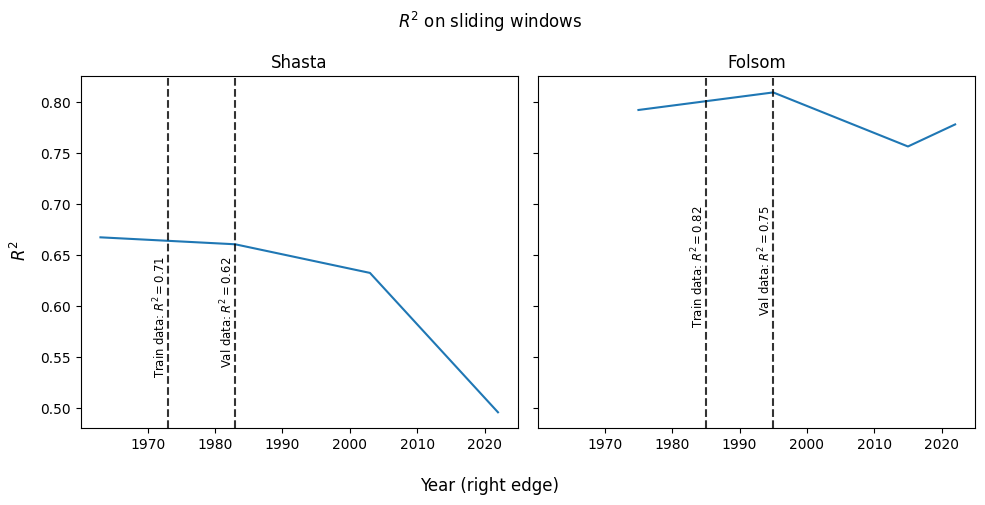

In [44]:
# Plot result
fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(10, 5))
axes[0].plot(sliding_years_shasta, R2_sliding_shasta)
axes[1].plot(sliding_years_folsom, R2_sliding_folsom)

# Label training and validation window
data_size_folsom = pd.to_datetime(right_window_folsom).year - pd.to_datetime(left_window_folsom).year + 1
train_size_folsom = int(round(data_size_folsom * train_frac))
# Folsom plot labels
axes[1].axvline(x=pd.to_datetime(left_window_folsom).year + train_size_folsom -1, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
axes[1].text(x=pd.to_datetime(left_window_folsom).year + train_size_folsom-0.9, y=0.7, s=f'Train data: $R^2={round(r2_train_folsom, 2)}$ ', ha='right', va='top', size='small', rotation=90)
axes[1].axvline(x=pd.to_datetime(right_window_folsom).year, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
axes[1].text(x=pd.to_datetime(right_window_folsom).year, y=0.7, s=f'Val data: $R^2={round(r2_val_folsom, 2)}$ ', ha='right', va='top', size='small', rotation=90)
axes[1].set_title('Folsom')
# Shasta plot labels
axes[0].axvline(x=pd.to_datetime(left_window_shasta).year + train_size_shasta -1, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
axes[0].text(x=pd.to_datetime(left_window_shasta).year + train_size_shasta-0.9, y=0.65, s=f'Train data: $R^2={round(r2_train_shasta, 2)}$ ', ha='right', va='top', size='small', rotation=90)
axes[0].axvline(x=pd.to_datetime(right_window_shasta).year, linestyle='--', color='black', alpha=0.8) #-1 to account for right edges being 12/31 instead of 1/1
axes[0].text(x=pd.to_datetime(right_window_shasta).year, y=0.65, s=f'Val data: $R^2={round(r2_val_shasta, 2)}$ ', ha='right', va='top', size='small', rotation=90)
axes[0].set_title('Shasta')

fig.suptitle('$R^2$ on sliding windows')
fig.supylabel('$R^2$')
fig.supxlabel('Year (right edge)')
plt.tight_layout()
plt.show()